<a href="https://colab.research.google.com/github/konung00/DS_ML/blob/main/line_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itertools import combinations
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.formula.api as sm
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_regression


root_path = 'gdrive/My Drive/datasets/lean_reg_ds/AirQualityUCI.csv'
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Pre-processing:

In [ ]:
def corr_test_pearson(df: pd.DataFrame) -> None:
  """ It tests for a statistical significance of correlation. H_0: no the correlation; H_1: there is the correlation """

  for comb in list(combinations(df.columns, 2)):
    r, p_val = st.pearsonr(df[comb[0]], df[comb[1]])
    result = "\033[92m there is a statistical significance \033[00m" if p_val < 0.05 else "\033[91m there is no a statistical significance \033[00m"
    print(f"Test between '{comb[0]}' and '{comb[1]}' male: r-Pearson = {r} and p-value = {p_val}. Thereby {result}.")


def explain_var_plot(pca: PCA) -> None:
  """ Plot a chart with cumulative explained variance ratio """

  sns.set(rc = {'figure.figsize':(15,8)})
  plt.bar(range(0, 10), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
  plt.step(range(0, 10), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal components')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()


def model_pipeline(X: pd.DataFrame, y: pd.Series, pipeline: Pipeline) -> None:
  """ Run a pipeline with X and y """

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  print(f'MODEL: {str(pipeline.steps)}\n', 
              'R^2 = %.3f\n'%r2_score(y_test, y_pred),
              'MSE = %.3f\n'%mean_squared_error(y_test, y_pred) , 
              'MAE = %.3f\n'%mean_absolute_error(y_test, y_pred))
  

def model_pipeline_grid(X: pd.DataFrame, y: pd.Series, pipeline: Pipeline, hparams: dict, cv: int) -> None:
  """ Run a search of best hyperparameters with pipeline """

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
  grid = GridSearchCV(pipeline, param_grid=hparams, cv=cv)
  grid.fit(X_train, y_train)
  print(f'MODEL: {str(pipeline.steps)}\n', 
              '\tBest value of cross test = %.3f\n'%grid.best_score_ ,
              '\tAccuracy on test data = %.3f\n'%grid.score(X_test, y_test), 
              '\tBest parameters: ', grid.best_params_)

#Data loading:

In [ ]:
df = pd.read_csv(root_path, sep=";", decimal=",", usecols=range(15))
df = df.dropna().replace(-200,np.nan)
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


Date and time is possible to combine in timestamp.

In [ ]:
date_time = pd.Series([datetime.strptime(x, "%d/%m/%Y%H.%M.%S") for x in df['Date'] + df['Time']])

In [ ]:
df.insert(0, 'time_stamp', date_time)
df.drop(["Time", "Date"], axis=1, inplace=True)

In [ ]:
df.head()

,time_stamp,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Let's adjust the column names:

In [ ]:
df.columns = [name[0].replace('.', '_') for name in df.columns.str.split("(")]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_stamp  9357 non-null   datetime64[ns]
 1   CO          7674 non-null   float64       
 2   PT08_S1     8991 non-null   float64       
 3   NMHC        914 non-null    float64       
 4   C6H6        8991 non-null   float64       
 5   PT08_S2     8991 non-null   float64       
 6   NOx         7718 non-null   float64       
 7   PT08_S3     8991 non-null   float64       
 8   NO2         7715 non-null   float64       
 9   PT08_S4     8991 non-null   float64       
 10  PT08_S5     8991 non-null   float64       
 11  T           8991 non-null   float64       
 12  RH          8991 non-null   float64       
 13  AH          8991 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.1 MB


#Exploratory data analysis:

Duplicates checking:

In [ ]:
df = df.drop_duplicates()
df.shape

(9357, 14)

No dupplicates detected. Let's look at NAN values:

In [ ]:
for name, col_nan in zip(df.columns, (df.isna().sum())):
        print(f"Column - '{name}' amout of NAN: {col_nan}; percent of NAN: {round(col_nan/len(df), 2) * 100}")

Column - 'time_stamp' amout of NAN: 0; percent of NAN: 0.0
Column - 'CO' amout of NAN: 1683; percent of NAN: 18.0
Column - 'PT08_S1' amout of NAN: 366; percent of NAN: 4.0
Column - 'NMHC' amout of NAN: 8443; percent of NAN: 90.0
Column - 'C6H6' amout of NAN: 366; percent of NAN: 4.0
Column - 'PT08_S2' amout of NAN: 366; percent of NAN: 4.0
Column - 'NOx' amout of NAN: 1639; percent of NAN: 18.0
Column - 'PT08_S3' amout of NAN: 366; percent of NAN: 4.0
Column - 'NO2' amout of NAN: 1642; percent of NAN: 18.0
Column - 'PT08_S4' amout of NAN: 366; percent of NAN: 4.0
Column - 'PT08_S5' amout of NAN: 366; percent of NAN: 4.0
Column - 'T' amout of NAN: 366; percent of NAN: 4.0
Column - 'RH' amout of NAN: 366; percent of NAN: 4.0
Column - 'AH' amout of NAN: 366; percent of NAN: 4.0


There is a lot of NAN values. Let's try to impute missing values with IterativeImputer class:

In [ ]:
numeric_cols = df.select_dtypes(np.float64).columns
imp = IterativeImputer(max_iter=10, random_state=4)
imp.fit(df.reset_index()[numeric_cols])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


IterativeImputer(random_state=4)

In [ ]:
imputed_data = pd.DataFrame(imp.transform(df.reset_index()[numeric_cols]))
imputed_data.columns = numeric_cols

In [ ]:
df[numeric_cols] = imputed_data

for name, col_nan in zip(df.columns, (df.isna().sum())):
        print(f"Column - '{name}' amout of NAN: {col_nan}; percent of NAN: {round(col_nan/len(df), 2) * 100}")

Column - 'time_stamp' amout of NAN: 0; percent of NAN: 0.0
Column - 'CO' amout of NAN: 0; percent of NAN: 0.0
Column - 'PT08_S1' amout of NAN: 0; percent of NAN: 0.0
Column - 'NMHC' amout of NAN: 0; percent of NAN: 0.0
Column - 'C6H6' amout of NAN: 0; percent of NAN: 0.0
Column - 'PT08_S2' amout of NAN: 0; percent of NAN: 0.0
Column - 'NOx' amout of NAN: 0; percent of NAN: 0.0
Column - 'PT08_S3' amout of NAN: 0; percent of NAN: 0.0
Column - 'NO2' amout of NAN: 0; percent of NAN: 0.0
Column - 'PT08_S4' amout of NAN: 0; percent of NAN: 0.0
Column - 'PT08_S5' amout of NAN: 0; percent of NAN: 0.0
Column - 'T' amout of NAN: 0; percent of NAN: 0.0
Column - 'RH' amout of NAN: 0; percent of NAN: 0.0
Column - 'AH' amout of NAN: 0; percent of NAN: 0.0


As we can see features have no more NAN values.

Let's check correlation:

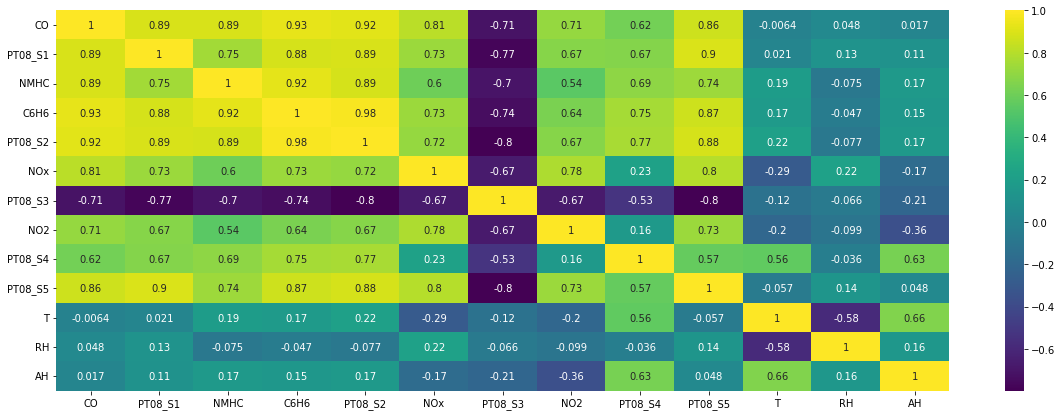

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(), annot=True, annot_kws={'size':10}, cmap=plt.cm.viridis)
plt.show()

We can see the strong mutual correlation between features. Good idea to test those.

Let's provide testing: $H_0$ - there is no correlation between features; $H_1$ - Correlation exists:

In [ ]:
corr_test_pearson(df[numeric_cols])

Test between 'CO' and 'PT08_S1' male: r-Pearson = 0.8900376831335922 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'NMHC' male: r-Pearson = 0.8907785514370875 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'C6H6' male: r-Pearson = 0.9341945915874581 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'PT08_S2' male: r-Pearson = 0.9178937826571717 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'NOx' male: r-Pearson = 0.8107620712573591 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'PT08_S3' male: r-Pearson = -0.7109125296897142 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'NO2' male: r-Pearson = 0.7125041096922365 and p-value = 0.0. Thereby  there is a statistical significance .
Test between 'CO' and 'PT08_S4' male: r-Pearson = 0.6179563846422328

Between 'CO' and 'T' as well as 'CO' and 'AH' there is the correlation without the statistical significance. However the rest of other include our target value have the significance.

Let's take a look at feature distribution:

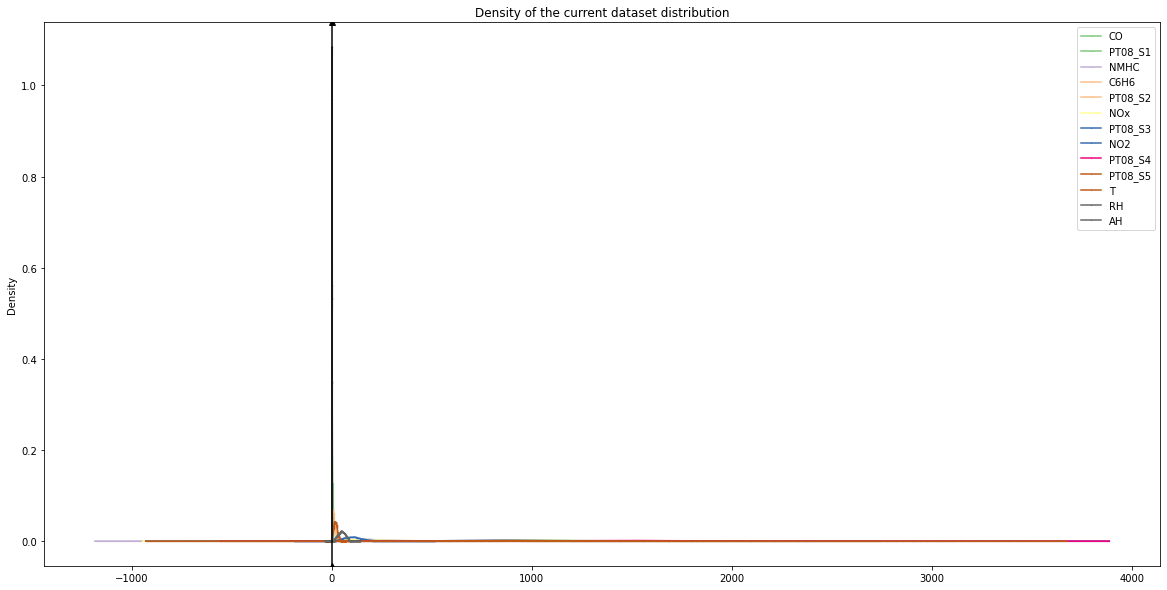

In [ ]:
fig ,ax = plt.subplots(figsize=(20,10))
df[numeric_cols].plot(kind="density", ax=ax,
                    style='-*', ms=0.6, cmap=plt.cm.Accent)
plt.axvline(x=0,**{'marker':'^','color':'black'})
ax.set_title("Density of the current dataset distribution")
plt.show()

It doesn't look good. The better way is to normalize the data.

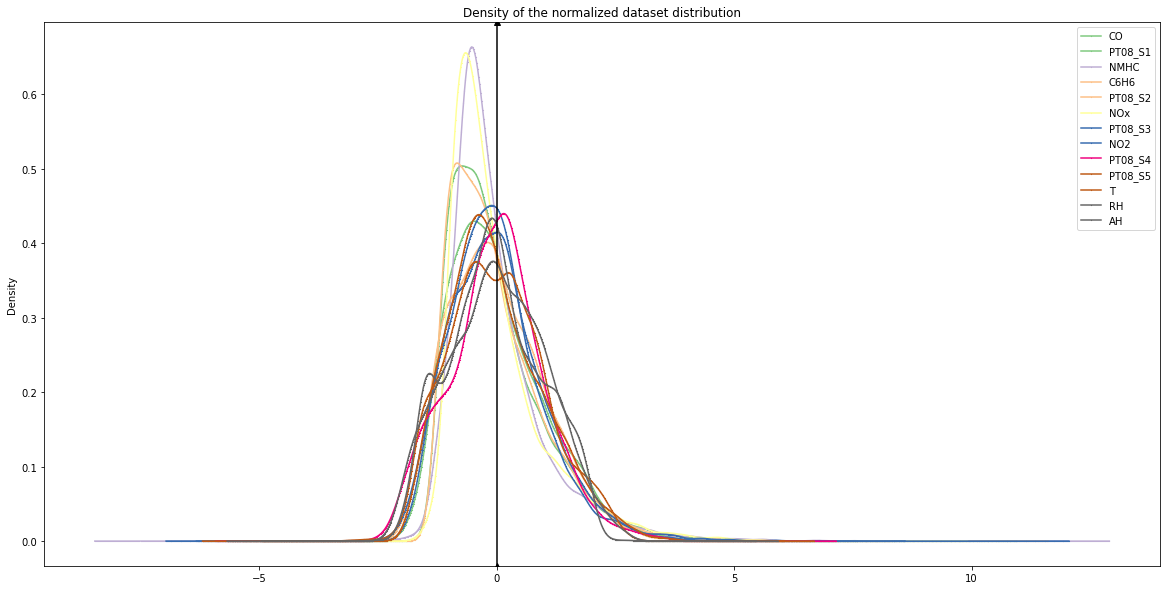

In [ ]:
df_norm = pd.DataFrame(StandardScaler().fit_transform(df[numeric_cols]))
df_norm.columns = numeric_cols

fig ,ax = plt.subplots(figsize=(20,10))
df_norm.plot(kind="density", ax=ax,
                    style='-*', ms=0.6, cmap=plt.cm.Accent)
plt.axvline(x=0,**{'marker':'^','color':'black'})
ax.set_title("Density of the normalized dataset distribution")
plt.show()

Now the distribution looks much better, we tend to see mostly populations skewed to the left of their mean (centered at 0).

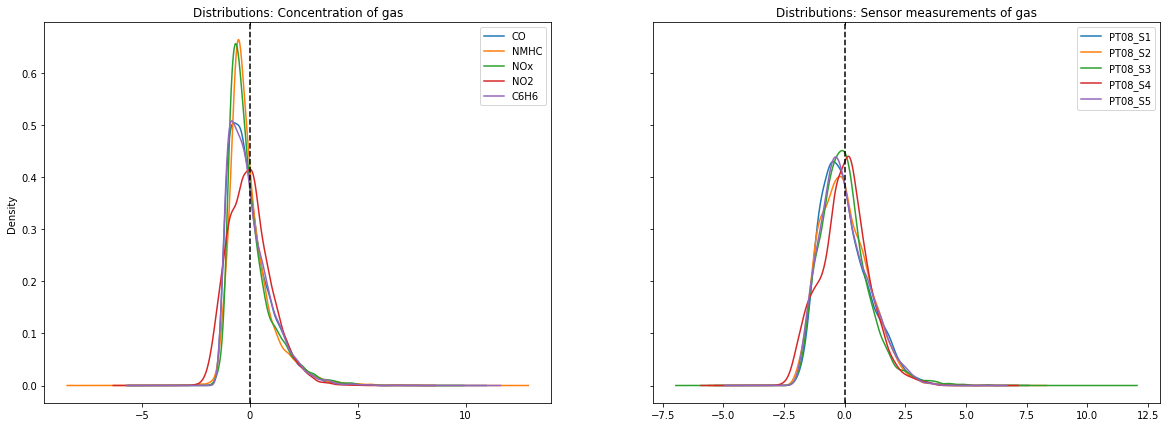

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20,7), sharey=True)
df_norm[["CO", "NMHC", "NOx", "NO2", "C6H6"]].plot(kind="density", ax=axs[0])
axs[0].axvline(x=0, color='black', marker="|" ,linestyle="--")
axs[0].set_title(r'Distributions: Concentration of gas')

df_norm[["PT08_S1", "PT08_S2", "PT08_S3", "PT08_S4", "PT08_S5"]].plot(kind="density", ax=axs[1])
axs[1].axvline(x=0, color='black', marker="|" ,linestyle="--")
axs[1].set_title(r'Distributions: Sensor measurements of gas')
plt.show()

The gas has much sharper peaks, while the sensors are designed to have a normal distribution.

#Feature Selection

Let's take a look at correlation of features against the target: 

In [ ]:
df.corr()[["C6H6"]]

,C6H6
CO,0.934195
PT08_S1,0.884585
NMHC,0.924543
C6H6,1.000000
PT08_S2,0.981961
NOx,0.731574
PT08_S3,-0.736894
NO2,0.637464
PT08_S4,0.754915
PT08_S5,0.866089


Based on corr table we can see that almost all features have strong r-value. However T, RH and AH features have rather week r-value thereby we could rid of those.

In [ ]:
print(sm.ols(formula="C6H6 ~ CO + PT08_S1 + NMHC + PT08_S2 + NOx + PT08_S3 + NO2 + PT08_S4 + T + RH + AH", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   C6H6   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.810e+05
Date:                Wed, 06 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:48:41   Log-Likelihood:                -6834.9
No. Observations:                9357   AIC:                         1.369e+04
Df Residuals:                    9345   BIC:                         1.378e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.7128      0.120   -198.196      0.0

Take a look at $R^2$: 0.995 it prety much excelente value, meanwhile F-value is a negligible number that means the model is significant. Let's perform the test without features: T, RH and AH.

In [ ]:
print(sm.ols(formula="C6H6 ~ CO + PT08_S1 + NMHC + PT08_S2 + NOx + PT08_S3 + NO2 + PT08_S4", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   C6H6   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.289e+05
Date:                Wed, 06 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:48:42   Log-Likelihood:                -7226.5
No. Observations:                9357   AIC:                         1.447e+04
Df Residuals:                    9348   BIC:                         1.454e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.5326      0.103   -247.273      0.0

As we can notice $R^2$ hasn't changed that means the features mentioned above have no explanatory power.

Let's try to select features with SelectPercentile class:

In [ ]:
X = df.drop(['time_stamp', 'C6H6'], axis=1)
y = df['C6H6']

In [ ]:
select = SelectPercentile(score_func=f_regression).fit(X, y)

In [ ]:
for i, f in zip(select.get_support(), select.feature_names_in_):
  print(f"feature: {f} - {i}") 

feature: CO - True
feature: PT08_S1 - False
feature: NMHC - False
feature: PT08_S2 - True
feature: NOx - False
feature: PT08_S3 - False
feature: NO2 - False
feature: PT08_S4 - False
feature: PT08_S5 - False
feature: T - False
feature: RH - False
feature: AH - False


SelectPercentile class pointed only two features: SO and PT08_S2. Let's figure out $R^2$ value:

In [ ]:
print(sm.ols(formula="C6H6 ~ CO + PT08_S2", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   C6H6   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.572e+05
Date:                Wed, 06 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:48:42   Log-Likelihood:                -15361.
No. Observations:                9357   AIC:                         3.073e+04
Df Residuals:                    9354   BIC:                         3.075e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.8675      0.077   -168.060      0.0

$R^2$ value has marked down thus ve cannot use those as is. What about principal component analysis:

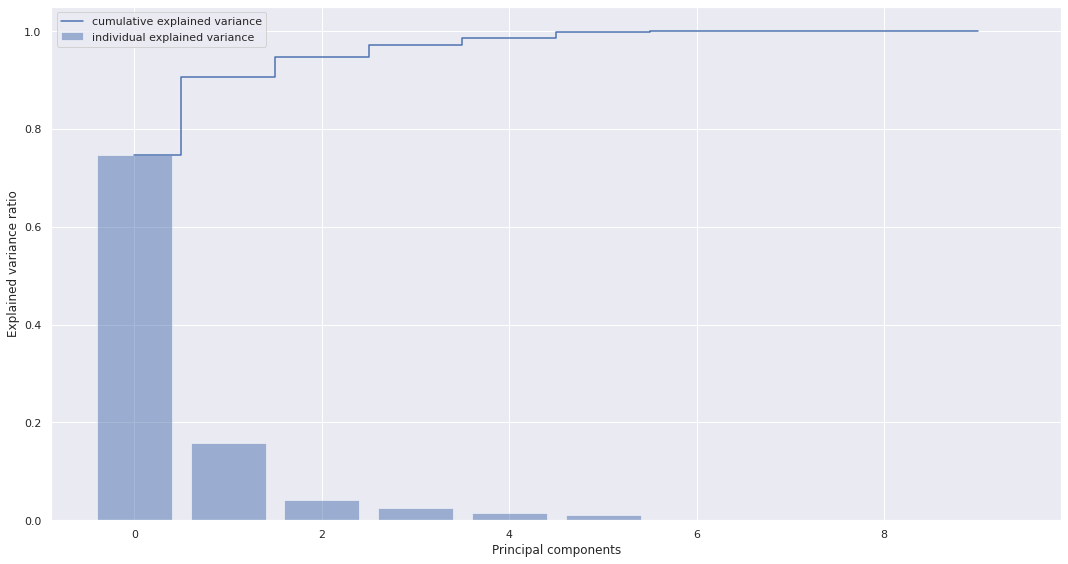

In [ ]:
X_reduced = X.drop(["CO", "PT08_S2"], axis=1)
pca = PCA()
pcomp = pca.fit_transform(X_reduced)
explain_var_plot(pca)

As we can see just one principal component explanes more than 60% of variance. However we could use the two components and cover more than 80%. Let's do so.

In [ ]:
pca = PCA(n_components=2)
pcomp = pca.fit_transform(X_reduced)
df_reduced = pd.DataFrame(data=pcomp, columns=["gas_sensor1", "gas_sensor2"])
df_reduced

,gas_sensor1,gas_sensor2
0,223.139507,-165.477497
1,-121.181053,-191.098986
2,-3.146721,-131.556566
3,111.401470,-91.116875
4,-86.020008,-76.428763
...,...,...
9352,673.697431,439.542972
9353,219.329119,322.531221
9354,86.204850,255.661186
9355,-313.436181,278.019668


Let's build scatter plots and check how new features interconnect with the target:

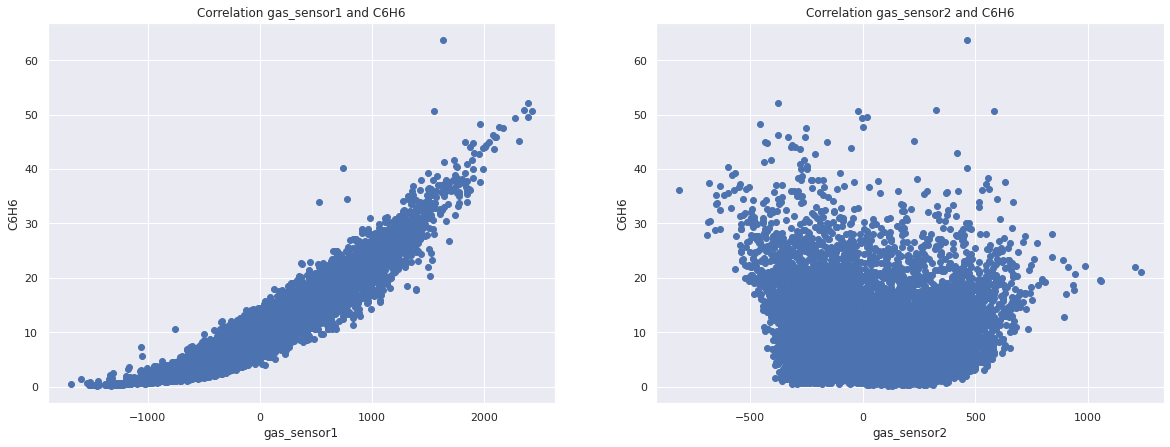

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ax[0].scatter(df_reduced["gas_sensor1"],y)
ax[0].set(xlabel='gas_sensor1',ylabel='C6H6')
ax[0].set_title(f"Correlation gas_sensor1 and C6H6")

ax[1].scatter(df_reduced["gas_sensor2"],y)
ax[1].set(xlabel='gas_sensor2',ylabel='C6H6')
ax[1].set_title(f"Correlation gas_sensor2 and C6H6")

plt.show()

The plots depict that gas_sensor1 has very good correlation with C6H6.

In conclusion we have got three options of datasets: 

In [ ]:
# Source dataset for the baseline
X.head()

,CO,PT08_S1,NMHC,PT08_S2,NOx,PT08_S3,NO2,PT08_S4,PT08_S5,T,RH,AH
0,2.6,1360.0,150.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
# Dataset has been reduced with PCA
X_pca = pd.concat([df[["CO", "PT08_S2"]], df_reduced], sort=False, axis=1)
X_pca.head()

,CO,PT08_S2,gas_sensor1,gas_sensor2
0,2.6,1046.0,223.139507,-165.477497
1,2.0,955.0,-121.181053,-191.098986
2,2.2,939.0,-3.146721,-131.556566
3,2.2,948.0,111.401470,-91.116875
4,1.6,836.0,-86.020008,-76.428763


In [ ]:
# Shrinked dataset based on statistical test
X_shrinked = X.drop(["T", "RH", "AH"], axis=1)
X_shrinked.head()

,CO,PT08_S1,NMHC,PT08_S2,NOx,PT08_S3,NO2,PT08_S4,PT08_S5
0,2.6,1360.0,150.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0
1,2.0,1292.0,112.0,955.0,103.0,1174.0,92.0,1559.0,972.0
2,2.2,1402.0,88.0,939.0,131.0,1140.0,114.0,1555.0,1074.0
3,2.2,1376.0,80.0,948.0,172.0,1092.0,122.0,1584.0,1203.0
4,1.6,1272.0,51.0,836.0,131.0,1205.0,116.0,1490.0,1110.0


#Linear models

Let's establish a baseline with a simple Linear regression class:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4)
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print('MODEL : Baseline\n', 
              'R^2 = %.3f\n'%r2_score(y_test, y_pred),
              'MSE = %.3f\n'%mean_squared_error(y_test, y_pred) , 
              'MAE = %.3f\n'%mean_absolute_error(y_test, y_pred))

MODEL : Baseline
 R^2 = 0.995
 MSE = 0.259
 MAE = 0.241



___

A pipeline with robust scaler class and linear regression:

In [ ]:
rob_scal_line_reg_pipeline = make_pipeline(RobustScaler(), LinearRegression())

Let's check the pipline without parameter adjustment:

In [ ]:
model_pipeline(X_pca, y, rob_scal_line_reg_pipeline)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 R^2 = 0.973
 MSE = 1.483
 MAE = 0.866



$R^2$ have decreased. It's a bed result.

In [ ]:
model_pipeline(X_shrinked, y, rob_scal_line_reg_pipeline)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 R^2 = 0.995
 MSE = 0.287
 MAE = 0.279



$R^2$ equals the baseline but RMSE and MAE have increased. Let's try to adjust the model's parameters:

Let's fulfill grid search and adjust some parameters:

In [ ]:
# dictionary of hyperparameter for linear regression class

lr_hparams = {'linearregression__fit_intercept':[True,False],'linearregression__positive':[True,False]}

In [ ]:
model_pipeline_grid(X, y, rob_scal_line_reg_pipeline, lr_hparams, 4)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.995
 	Best parameters:  {'linearregression__fit_intercept': True, 'linearregression__positive': False}


Base dataset has shown the same result.

In [ ]:
model_pipeline_grid(X_pca, y, rob_scal_line_reg_pipeline, lr_hparams, 4)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.972
 	Accuracy on test data = 0.973
 	Best parameters:  {'linearregression__fit_intercept': True, 'linearregression__positive': False}


PCA dataset accuracy is lower the baseline.

In [ ]:
model_pipeline_grid(X_shrinked, y, rob_scal_line_reg_pipeline, lr_hparams, 4)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.995
 	Best parameters:  {'linearregression__fit_intercept': True, 'linearregression__positive': False}


Shrinked dataset accuracy equals the baseline.

It would be good idea to try **linear model with l1, l2 regularization**:

In [ ]:
# Pipeline with a ridge class
rob_scal_ridge_pipe = make_pipeline(RobustScaler(), Ridge())

# Pipeline with a lasso class
rob_scal_lasso_pipe = make_pipeline(RobustScaler(), Lasso())

# Pipeline with a elasticnet class
rob_scal_elnet_pipe = make_pipeline(RobustScaler(), ElasticNet())

Let's check ***Ridge algorithm***:

In [ ]:
model_pipeline(X, y, rob_scal_ridge_pipe)

MODEL: [('robustscaler', RobustScaler()), ('ridge', Ridge())]
 R^2 = 0.995
 MSE = 0.258
 MAE = 0.241



It fits the baseline.

In [ ]:
model_pipeline(X_pca, y, rob_scal_ridge_pipe)

MODEL: [('robustscaler', RobustScaler()), ('ridge', Ridge())]
 R^2 = 0.973
 MSE = 1.483
 MAE = 0.866



It doesn't fit the baseline.

In [ ]:
model_pipeline(X_shrinked, y, rob_scal_ridge_pipe)

MODEL: [('robustscaler', RobustScaler()), ('ridge', Ridge())]
 R^2 = 0.995
 MSE = 0.287
 MAE = 0.279



It fits the baseline.

Ridge test with default parameters has shown the same result as the linear regression class. What about tuning ridge hyperparameters

In [ ]:
#ridge_hparams = {'ridge__alpha':[np.arange(0, 1, 0.01)], 'ridge__solver':["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"]}
ridge_hparams = {'ridge__alpha':[0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]}

In [ ]:
model_pipeline_grid(X, y, rob_scal_ridge_pipe, ridge_hparams, cv=10)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.995
 	Best parameters:  {'ridge__alpha': 0.0}


In [ ]:
model_pipeline_grid(X_pca, y, rob_scal_ridge_pipe, ridge_hparams, cv=10)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.972
 	Accuracy on test data = 0.973
 	Best parameters:  {'ridge__alpha': 0.25}


In [ ]:
model_pipeline_grid(X_shrinked, y, rob_scal_ridge_pipe, ridge_hparams, cv=10)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.995
 	Best parameters:  {'ridge__alpha': 0.0}


In this case best result has been provided by baseline dataset and shrinked dataset.

Now let's check ***Lasso algorithm***:

In [ ]:
model_pipeline(X, y, rob_scal_lasso_pipe)

MODEL: [('robustscaler', RobustScaler()), ('lasso', Lasso())]
 R^2 = 0.940
 MSE = 3.346
 MAE = 1.349



In [ ]:
model_pipeline(X_pca, y, rob_scal_lasso_pipe)

MODEL: [('robustscaler', RobustScaler()), ('lasso', Lasso())]
 R^2 = 0.932
 MSE = 3.761
 MAE = 1.245



In [ ]:
model_pipeline(X_shrinked, y, rob_scal_lasso_pipe)

MODEL: [('robustscaler', RobustScaler()), ('lasso', Lasso())]
 R^2 = 0.940
 MSE = 3.346
 MAE = 1.349



All test are lower the baseline. Default lasso doesn't suit our case. Let's try hyperparameters tuning. 

In [ ]:
lasso_hparams = {'lasso__alpha':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]}

In [ ]:
model_pipeline_grid(X, y, rob_scal_lasso_pipe, lasso_hparams, cv=10)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.995
 	Best parameters:  {'lasso__alpha': 0.01}


In [ ]:
model_pipeline_grid(X_pca, y, rob_scal_lasso_pipe, lasso_hparams, cv=10)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.972
 	Accuracy on test data = 0.973
 	Best parameters:  {'lasso__alpha': 0.01}


In [ ]:
model_pipeline_grid(X_shrinked, y, rob_scal_lasso_pipe, lasso_hparams, cv=10)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.994
 	Best parameters:  {'lasso__alpha': 0.01}


As we can see tuned lasso model can provide good result only on base dataset.

Now let's check ***ElasticNet algorithm***:

In [ ]:
model_pipeline(X, y, rob_scal_elnet_pipe)

MODEL: [('robustscaler', RobustScaler()), ('elasticnet', ElasticNet())]
 R^2 = 0.928
 MSE = 4.010
 MAE = 1.467



In [ ]:
model_pipeline(X_pca, y, rob_scal_elnet_pipe)

MODEL: [('robustscaler', RobustScaler()), ('elasticnet', ElasticNet())]
 R^2 = 0.861
 MSE = 7.732
 MAE = 1.958



In [ ]:
model_pipeline(X_shrinked, y, rob_scal_elnet_pipe)

MODEL: [('robustscaler', RobustScaler()), ('elasticnet', ElasticNet())]
 R^2 = 0.928
 MSE = 4.010
 MAE = 1.467



Test shows that dafault ElasticNet model doesn't fit our case. Let's try hyperparameters tuning:

In [ ]:
elnet_hparams = {'elasticnet__alpha':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99],
        'elasticnet__l1_ratio':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]}

In [ ]:
model_pipeline_grid(X, y, rob_scal_elnet_pipe, elnet_hparams, cv=3)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.995
 	Accuracy on test data = 0.995
 	Best parameters:  {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.99}


Fits the baseline.

In [ ]:
model_pipeline_grid(X_pca, y, rob_scal_elnet_pipe, elnet_hparams, cv=3)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.972
 	Accuracy on test data = 0.973
 	Best parameters:  {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.99}


It's lower the baseline.

In [ ]:
model_pipeline_grid(X_shrinked, y, rob_scal_elnet_pipe, elnet_hparams, cv=3)

MODEL: [('robustscaler', RobustScaler()), ('linearregression', LinearRegression())]
 	Best value of cross test = 0.994
 	Accuracy on test data = 0.994
 	Best parameters:  {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.99}


It's lower the baseline.

As the conclusion, we tested several linear models: Linear regression, Ridge, Lasso and ElasticNet.
In our case the best model could be applied are:
- Linear Regression (fit_intercept=True, positive=False) showed $R^2$: 0.995
- Ridge (alpha=0.0) showed $R^2$: 0.995
- Lasso (alpha=0.01) showed $R^2$: 0.995
- ElasticNet (alpha=0.01, l1_ratio=0.99) showed $R^2$: 0.994

The best error ratio showed Linear Regression class:
- MSE = 0.258
- MAE = 0.241

The best dataset is the native dataset without feature engineering process.
___